## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [68]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [69]:
class MyKNeighborsClassifier(BaseEstimator):

    def __init__(self, n_neighbors=2, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        if self.algorithm == 'brute':
            self.predictor = self.brute_predict_output
        elif self.algorithm == 'kd_tree':
            self.predictor = self.kd_tree_predict_output

    def fit(self, X, y):
        self.X = X
        self.y = y.reshape(y.shape[0], -1)
        self.n_samples = self.X.shape[0]
        self.n_features = self. X.shape[1]
        self.n_outputs = self.y.shape[1]

        if self.algorithm == 'kd_tree':
            self.kd_tree_fit(X, y)

    def kd_tree_fit(self, X, y):
        self.kd_tree = KDTree(X, leaf_size=10)

    def predict(self, X):
        ret = np.asarray([self.predict_sample(obj) for obj in X])

        if self.n_outputs == 1:
            ret = ret.reshape(X.shape[0],)
        return ret

    def predict_sample(self, x):
        return np.asarray([self.predictor(x, self.y[::, i]) for i in range(self.n_outputs)])

    def brute_predict_output(self, x, y):
        dists = ((self.X - x) ** 2).sum(axis=1)
        best_args = np.argpartition(dists, self.n_neighbors)[:self.n_neighbors]
        best_dists = dists[best_args]
        sorted_args = best_args[np.argsort(best_dists)]
        final_values = y[sorted_args]
        counts = np.unique(final_values, return_counts=True)
        return counts[0][np.argmax(counts[1])]

    def kd_tree_predict_output(self, x, y):
        nearest = self.kd_tree.query(x.reshape((-1, self.n_features)), self.n_neighbors)
        outputs = y[nearest[1]]
        counts = np.unique(outputs, return_counts=True)
        return counts[0][np.argmax(counts[1])]

    def score(self, x, y):
        return 0

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [70]:
iris = datasets.load_iris()

In [71]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [72]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [73]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [74]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs(accuracy_score(y_test, my_clf_pred) - accuracy_score(y_test, sklearn_pred)) < 0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [75]:
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [76]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [77]:
%time clf.predict(X_test)

Wall time: 1 ms


array([0, 1, 2, 0, 0, 2, 2, 1, 2, 0, 2, 1, 1, 1, 0])

In [78]:
%time my_clf.predict(X_test)

Wall time: 1e+03 µs


array([0, 1, 2, 0, 0, 2, 2, 1, 2, 0, 2, 1, 1, 1, 0])

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [79]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [80]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [81]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [82]:
%time my_clf.fit(X_train, y_train)

Wall time: 1 ms


In [83]:
%time clf.predict(X_test)

Wall time: 1 ms


array([0, 1, 2, 0, 1, 0, 2, 1, 1, 1, 2, 0, 2, 0, 1])

In [84]:
%time my_clf.predict(X_test)

Wall time: 999 µs


array([0, 1, 2, 0, 1, 0, 2, 1, 1, 1, 2, 0, 2, 0, 1])

In [85]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs(accuracy_score(y_test, my_clf_pred) - accuracy_score(y_test, sklearn_pred)) < 0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [86]:
newsgroups = fetch_20newsgroups(subset='train', remove=['headers','footers', 'quotes'])

In [87]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.


In [88]:
vectorizer = CountVectorizer(max_df=0.05)
X = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [89]:
n_folds = 3
kf = KFold(n_splits=n_folds)
groups = [[X_train, X_test] for X_train, X_test in kf.split(X)]

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [90]:
def count_score(X, y, n_neighbors, cv=3, metric='minkowski'):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    return cross_validate(knn, X, y, cv=cv)['test_score'].mean()


def do_calc(X, y, rang, cv=3, metric='minkowski'):
    return[count_score(X, y, i, cv, metric) for i in rang]

In [91]:
stat = np.asarray(do_calc(X, target, range(1, 11), 3))
print(stat)
x_ax = np.arange(1, stat.shape[0] + 1)

[0.27797273 0.21804746 0.21159471 0.22379236 0.22167081 0.21822383
 0.21283253 0.20867862 0.20505513 0.204348  ]


In [92]:
best_pos = np.max(stat)
print(best_pos)

0.27797272706565396


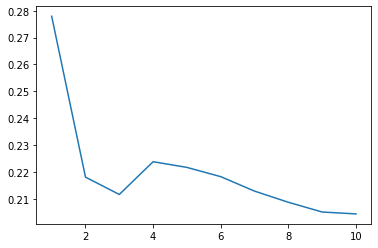

In [93]:
plt.plot(x_ax, stat)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [94]:
tfidf = TfidfVectorizer(max_df=1.)
tf_X = tfidf.fit_transform(data)

In [95]:
stat = np.asarray(do_calc(tf_X, target, range(1, 11), 3, cosine_distances))
x_ax = np.arange(1, stat.shape[0] + 1)

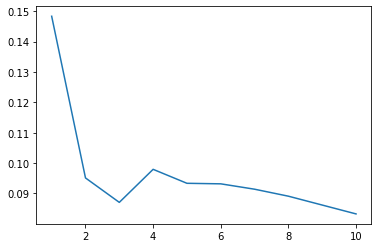

In [96]:
plt.plot(x_ax, stat)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [97]:
newsgroups = fetch_20newsgroups(subset='test', remove=['headers', 'footers', 'quotes'])

In [98]:
for_vocabulary = data + newsgroups['data']
vec = CountVectorizer()
vec = vec.fit(for_vocabulary)
vocabulary = vec.vocabulary_

In [99]:
vectorizer = CountVectorizer(max_df=0.05, vocabulary=vocabulary)
X_test = vectorizer.fit_transform(newsgroups['data'])
target_test = newsgroups['target']

X_train = vectorizer.fit_transform(data)

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [100]:
# Лучше показали настройки: 1 сосед, метрика по минковски, max_df=0.05

In [101]:
knn1 = KNeighborsClassifier(n_neighbors=1, metric='minkowski')
knn1 = knn1.fit(X_train, target)

In [102]:
pred = knn1.predict(X_test)

In [103]:
accuracy_score(target_test, pred)

0.16848114710568243

In [104]:
# 4 соседа дали в среднем хорший результат

In [105]:
knn2 = KNeighborsClassifier(n_neighbors=4, metric='minkowski')
knn2 = knn2.fit(X_train, target)

In [106]:
pred = knn2.predict(X_test)

In [107]:
accuracy_score(target_test, pred)

0.15852363250132767

In [108]:
# мало отличается от результата с одним соседом, но так же хуже

In [109]:
# можеть быть ограничить словарь не так сильно, max_df=0.3

In [110]:
vectorizer2 = CountVectorizer(max_df=0.3, vocabulary=vocabulary)
X_test = vectorizer2.fit_transform(newsgroups['data'])
target_test = newsgroups['target']

X_train = vectorizer2.fit_transform(data)

In [111]:
knn3 = KNeighborsClassifier(n_neighbors=1, metric='minkowski')
knn3 = knn3.fit(X_train, target)

In [112]:
pred = knn3.predict(X_test)

In [113]:
accuracy_score(target_test, pred)

0.16848114710568243

In [114]:
# дало абсолюто похожий результат, попробуем убрать ограничение на частотность

In [115]:
vectorizer3 = CountVectorizer(vocabulary=vocabulary)
X_test = vectorizer3.fit_transform(newsgroups['data'])
target_test = newsgroups['target']

X_train = vectorizer3.fit_transform(data)

In [116]:
knn4 = KNeighborsClassifier(n_neighbors=1, metric='minkowski')
knn4 = knn4.fit(X_train, target)

In [117]:
pred = knn4.predict(X_test)

In [118]:
accuracy_score(target_test, pred)

0.16848114710568243

In [119]:
# В итоге результат 0.16848114710568243 при тестировании
# оказался хуже результата кросс-валидации 0.27797273
# Это происходит из-за влияния переобучения, так как в тесте
# много неизвестных заранее слов.
# Также влияет отсутсвие проверки на схожесть самих слов,
# а именно проверка лишь на точное совпадение.